📤 Upload Content Image


Saving m-transformed.jpeg to m-transformed.jpeg
📤 Upload Style Image


Saving m-transformed (1).jpeg to m-transformed (1).jpeg


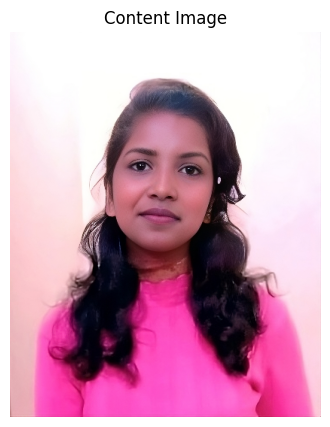

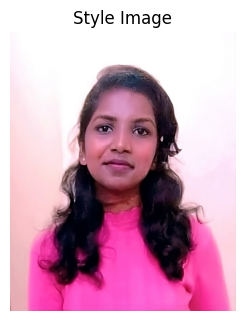

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🎨 Training Neural Style Transfer...


In [ ]:
# 📌 Neural Style Transfer in Google Colab
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import PIL.Image
from tensorflow.keras.preprocessing import image
from google.colab import files
import os

# ✅ Function to Upload Images
def upload_file(label):
    uploaded = files.upload()
    if uploaded:
        return list(uploaded.keys())[0]
    else:
        raise FileNotFoundError(f"❌ No file uploaded for {label}.")

# ✅ Upload Content & Style Images
print("📤 Upload Content Image")
content_path = upload_file("Content Image")

print("📤 Upload Style Image")
style_path = upload_file("Style Image")

# ✅ Load & Process Images
def load_img(path):
    max_dim = 512
    img = image.load_img(path)
    img = image.img_to_array(img)

    # Resize maintaining aspect ratio
    long_dim = max(img.shape[:2])
    scale = max_dim / long_dim
    img = tf.image.resize(img, (round(img.shape[0] * scale), round(img.shape[1] * scale)))
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

content_image = load_img(content_path)
style_image = load_img(style_path)

# ✅ Display Images
def imshow(img, title=None):
    img = np.squeeze(img, axis=0)  # Remove batch dimension
    img = np.clip(img / 255.0, 0, 1)  # Normalize
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_image, "Content Image")
plt.subplot(1, 2, 2)
imshow(style_image, "Style Image")

# ✅ Load Pretrained VGG19 Model for Feature Extraction
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# ✅ Extract Style & Content Layers
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# ✅ Build Feature Extraction Model
def get_vgg_model():
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

feature_extractor = get_vgg_model()

# ✅ Compute Style & Content Features
def get_feature_representations(model, content_image, style_image):
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    style_features = [layer for layer in style_outputs[:num_style_layers]]
    content_features = [layer for layer in content_outputs[num_style_layers:]]

    return style_features, content_features

style_features, content_features = get_feature_representations(feature_extractor, content_image, style_image)

# ✅ Style Loss - Compute Gram Matrix
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(tf.shape(a)[0], tf.float32)

# ✅ Compute Style & Content Loss
def compute_loss(model, style_targets, content_targets, image):
    outputs = model(image)
    style_outputs = outputs[:num_style_layers]
    content_outputs = outputs[num_style_layers:]

    style_loss = tf.add_n([tf.reduce_mean((gram_matrix(style_outputs[i]) - gram_matrix(style_targets[i])) ** 2)
                           for i in range(num_style_layers)])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[i] - content_targets[i]) ** 2)
                             for i in range(num_content_layers)])

    style_loss *= 1.0
    content_loss *= 1e4

    total_loss = style_loss + content_loss
    return total_loss

# ✅ Train the Model
image_var = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        loss = compute_loss(feature_extractor, style_features, content_features, image)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0, 255))

# ✅ Run Style Transfer
print("🎨 Training Neural Style Transfer...")
start_time = time.time()

epochs = 10
steps_per_epoch = 100
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(image_var)
    print(f"Epoch {epoch+1}/{epochs} completed.")

end_time = time.time()
print(f"✅ Training completed in {end_time - start_time:.2f} seconds.")

# ✅ Save & Show Final Stylized Image
final_image = np.array(image_var.numpy().astype(np.uint8)).squeeze()
final_image = PIL.Image.fromarray(final_image)

plt.figure(figsize=(8, 8))
plt.imshow(final_image)
plt.axis("off")
plt.title("🎨 Stylized Image")
plt.show()

# ✅ Save & Download Image
final_image.save("stylized_image.png")
files.download("stylized_image.png")
print("📥 Stylized image saved and ready to download!")
